### Building House Price Predicition Model

**Downloading the Dataset**

In [4]:
# Download dataset directly
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip
!unzip house-prices-advanced-regression-techniques.zip

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


'unzip' is not recognized as an internal or external command,
operable program or batch file.


**Importing Libraries**

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt

**Using Train.csv as Full Dataset**

In [ ]:
df = pd.read_csv("data/train.csv")
#pd.reset_option("display.max_columns",None) #alternative use - pd.option_context 
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df.shape

(1460, 81)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Checking the NA values in each features**

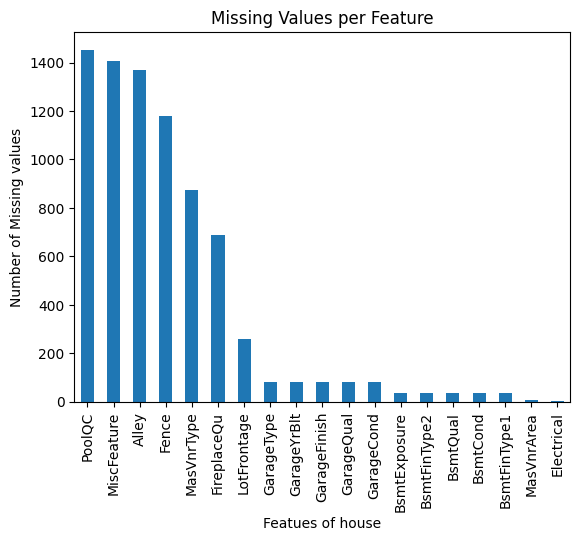

In [9]:
nulls = df.isnull().sum()
plot_nulls = nulls[nulls > 0].sort_values(ascending=False)
plot = plot_nulls.plot(kind='bar')
plt.xlabel("Featues of house")
plt.ylabel("Number of Missing values")
plt.title("Missing Values per Feature")
plt.show()

**Identifying the Unique values**

In [10]:
unique_cols = {}
for cols in df.columns:
    unique_cols["cols"] = df[cols].unique()
    print(f"Column name {cols} with unique values {df[cols].unique()}")
    print("-"*50)   
        

Column name Id with unique values [   1    2    3 ... 1458 1459 1460]
--------------------------------------------------
Column name MSSubClass with unique values [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
--------------------------------------------------
Column name MSZoning with unique values ['RL' 'RM' 'C (all)' 'FV' 'RH']
--------------------------------------------------
Column name LotFrontage with unique values [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153. 

**Identifying Numerical and Plotting Them**

In [11]:
numerical_columns=df.select_dtypes(include=["int64","float64"]).drop("Id", axis = 1).columns.to_list() #removed Id

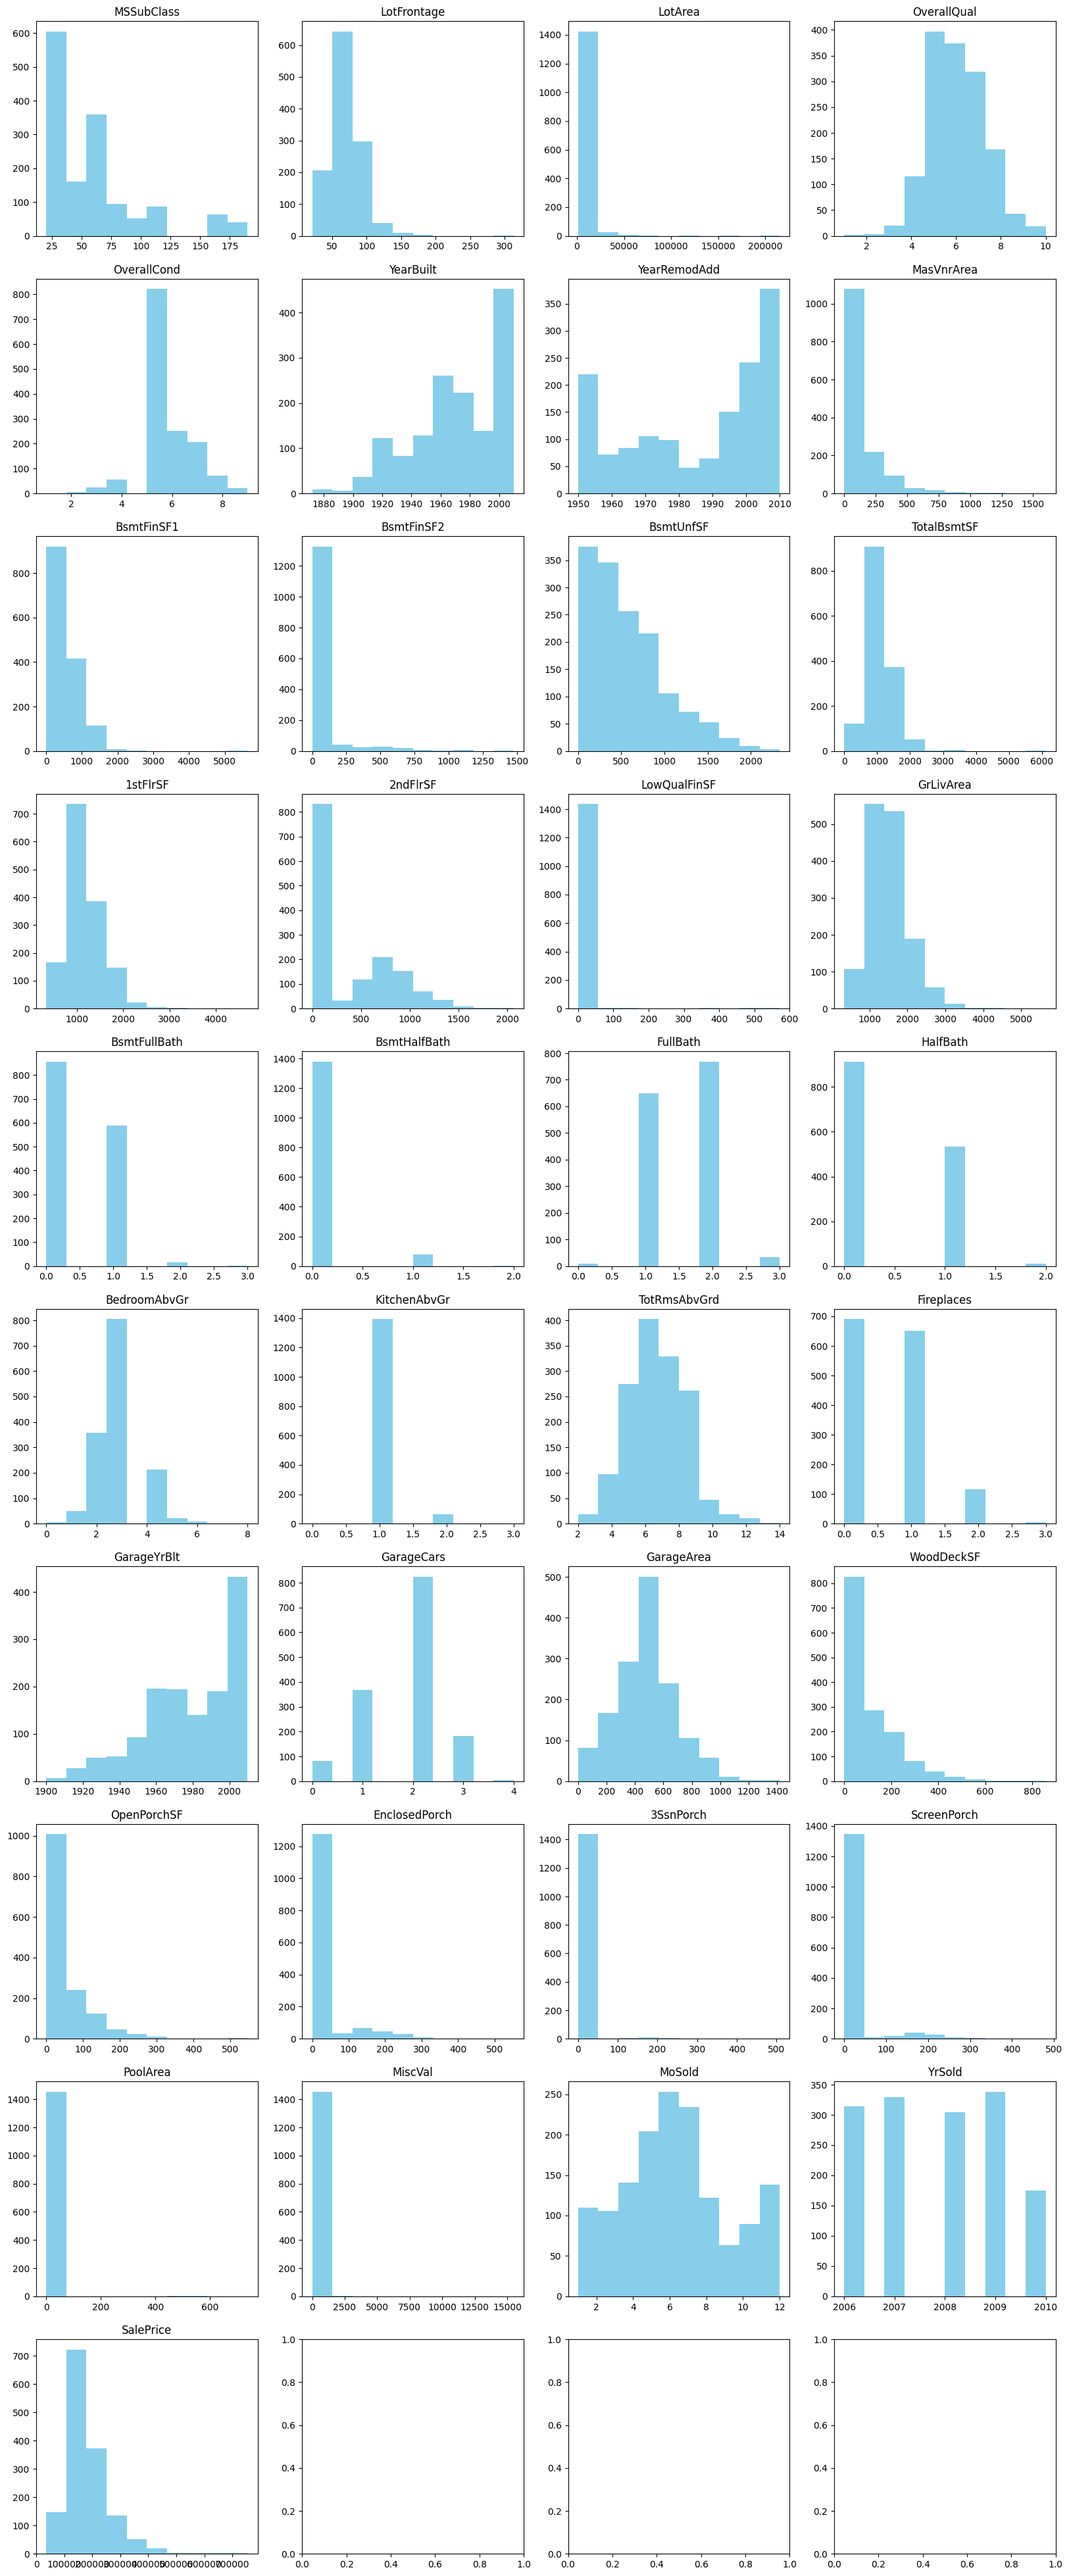

In [12]:
length_numerical_column = len(numerical_columns)
rows_req = math.ceil(length_numerical_column/4) #calculating number of rows 
fig , axes = plt.subplots(rows_req, 4 , figsize = (20,rows_req*5))
axes = axes.flatten()
for i, cols in enumerate(numerical_columns):
    axes[i].hist(df[cols], color = "skyblue")
    axes[i].set_title(cols)
    

**Insights**
* Most of the features are skewed.
* There are few columns with missing values. We need to impute them accordingly.
* Scaling  is needed as the values are on different scale which will create the problem for non-tree based models.


**Checking the correltion with the SalePrice**


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

C:\Users\faraz_81kv05g\AppData\Local\Temp\ipykernel_17348\905190449.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette="magma")


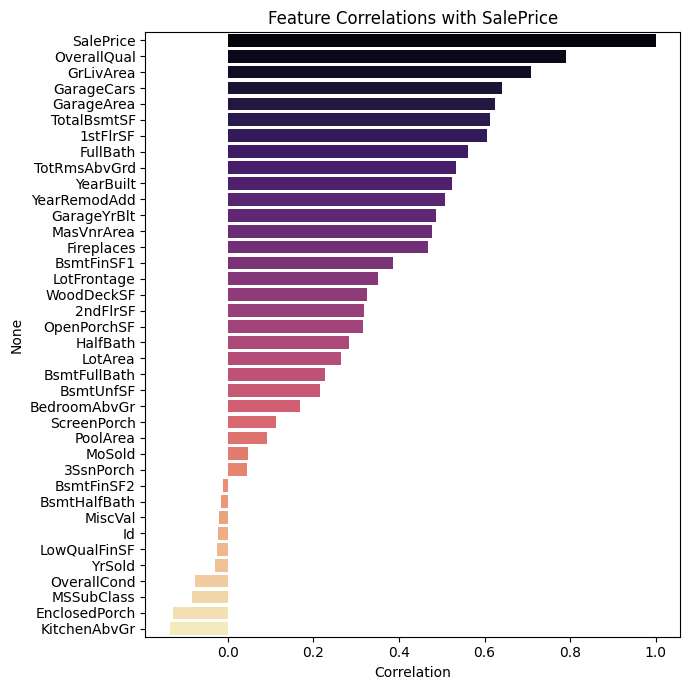

In [53]:
# Check correlation with SalePrice
correlations = df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)
print(correlations)
plt.figure(figsize=(7,7))
sns.barplot(x=correlations.values, y=correlations.index, palette="magma")
plt.title("Feature Correlations with SalePrice")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

**Removing Features tha are not less realted to SalePrice**

In [14]:
less_rel_features = correlations[abs(correlations)<0.1].index.to_list()
print(f"The less relevant features are : {less_rel_features} and they are total {len(less_rel_features)} in number.")
df.drop(less_rel_features, inplace=True, axis  = 1)

The less relevant features are : ['PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'Id', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass'] and they are total 11 in number.


In [15]:
df.head(3)

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,61,0,0,NaN,NaN,NaN,WD,Normal,208500
1,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,...,298,0,0,0,NaN,NaN,NaN,WD,Normal,181500
2,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,0,42,0,0,NaN,NaN,NaN,WD,Normal,223500


**Remove Higher NA Features**

In [16]:
# updating numerical columns
numerical_columns = df.select_dtypes(include = ["int64", "float64"]).columns.to_list()
## checking if any column have more than 80% percent for missing values.
missing_value_columns = df.isna().sum()[df.isna().sum()>0]
missing_percentage_per_feature = (missing_value_columns*100/df.shape[0])
for feature in missing_value_columns.index:
    print(f"The percentage of missing values in {feature} is {missing_percentage_per_feature[feature]}")
drop_higher_na_columns = missing_value_columns[missing_percentage_per_feature >80]
df.drop(drop_higher_na_columns.index.to_list(),inplace = True, axis =1 )

The percentage of missing values in LotFrontage is 17.73972602739726
The percentage of missing values in Alley is 93.76712328767124
The percentage of missing values in MasVnrType is 59.726027397260275
The percentage of missing values in MasVnrArea is 0.547945205479452
The percentage of missing values in BsmtQual is 2.5342465753424657
The percentage of missing values in BsmtCond is 2.5342465753424657
The percentage of missing values in BsmtExposure is 2.6027397260273974
The percentage of missing values in BsmtFinType1 is 2.5342465753424657
The percentage of missing values in BsmtFinType2 is 2.6027397260273974
The percentage of missing values in Electrical is 0.0684931506849315
The percentage of missing values in FireplaceQu is 47.26027397260274
The percentage of missing values in GarageType is 5.5479452054794525
The percentage of missing values in GarageYrBlt is 5.5479452054794525
The percentage of missing values in GarageFinish is 5.5479452054794525
The percentage of missing values in 

In [17]:
df.head(3)

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,SalePrice
0,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,TA,Y,0,61,0,0,WD,Normal,208500
1,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,TA,TA,Y,298,0,0,0,WD,Normal,181500
2,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,TA,Y,0,42,0,0,WD,Normal,223500


**Checking for Outliers Using Boxplots**

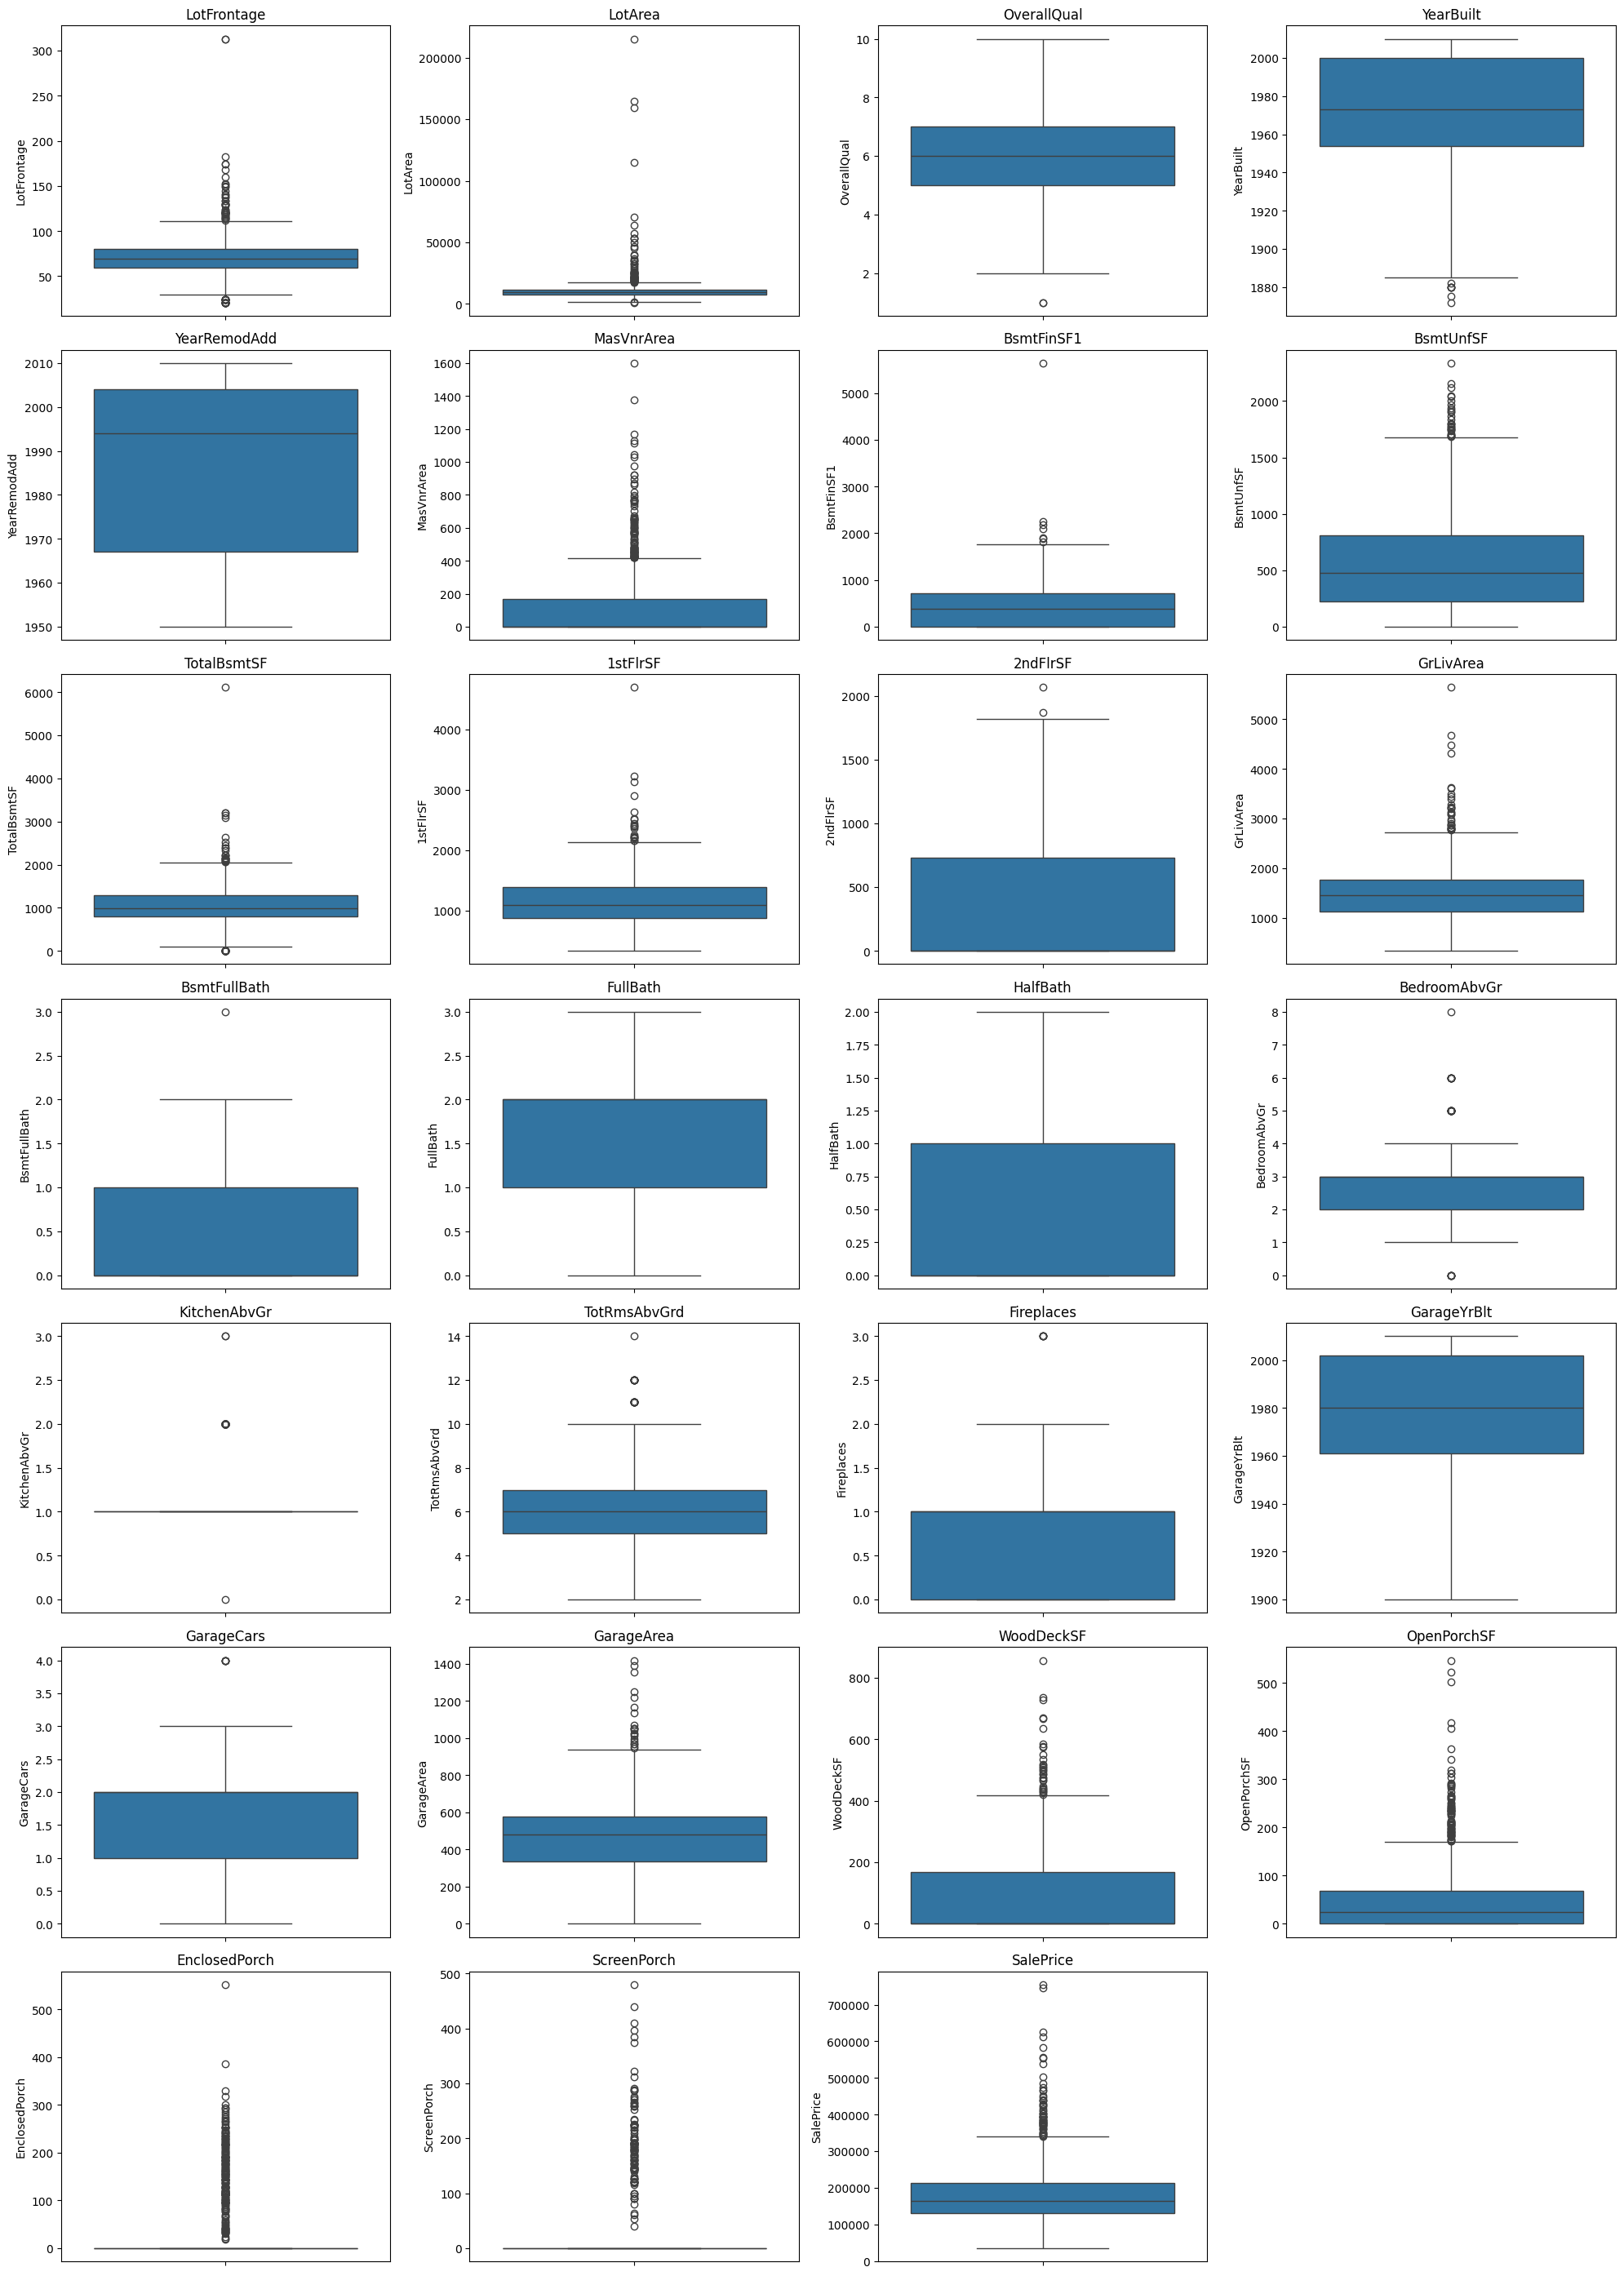

In [18]:
import math

# Calculate grid size
n_cols = len(numerical_columns)
n_rows = math.ceil(n_cols / 4)  # 4 plots per row

fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*4))
axes = axes.flatten()  # Make 1D array

for i, col in enumerate(numerical_columns):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(col)

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()

**Heatmap for Numerical columns**

<Axes: >

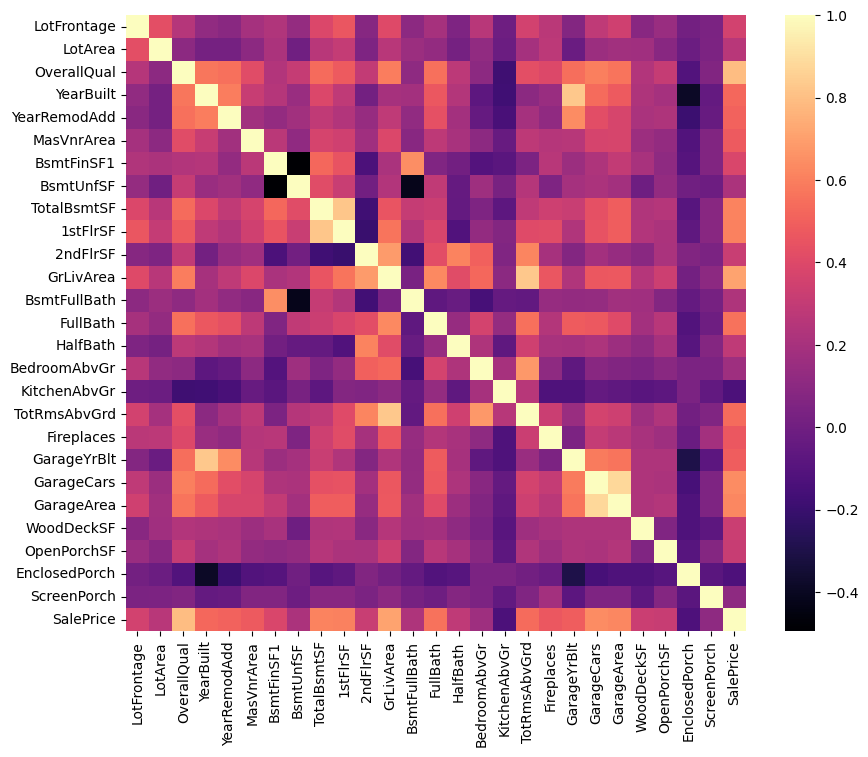

In [19]:
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(numeric_only = True), cmap = "magma",cbar = True )

**Plotting Scatter Plot to Understand the Relation of Numerical Features with the Price**

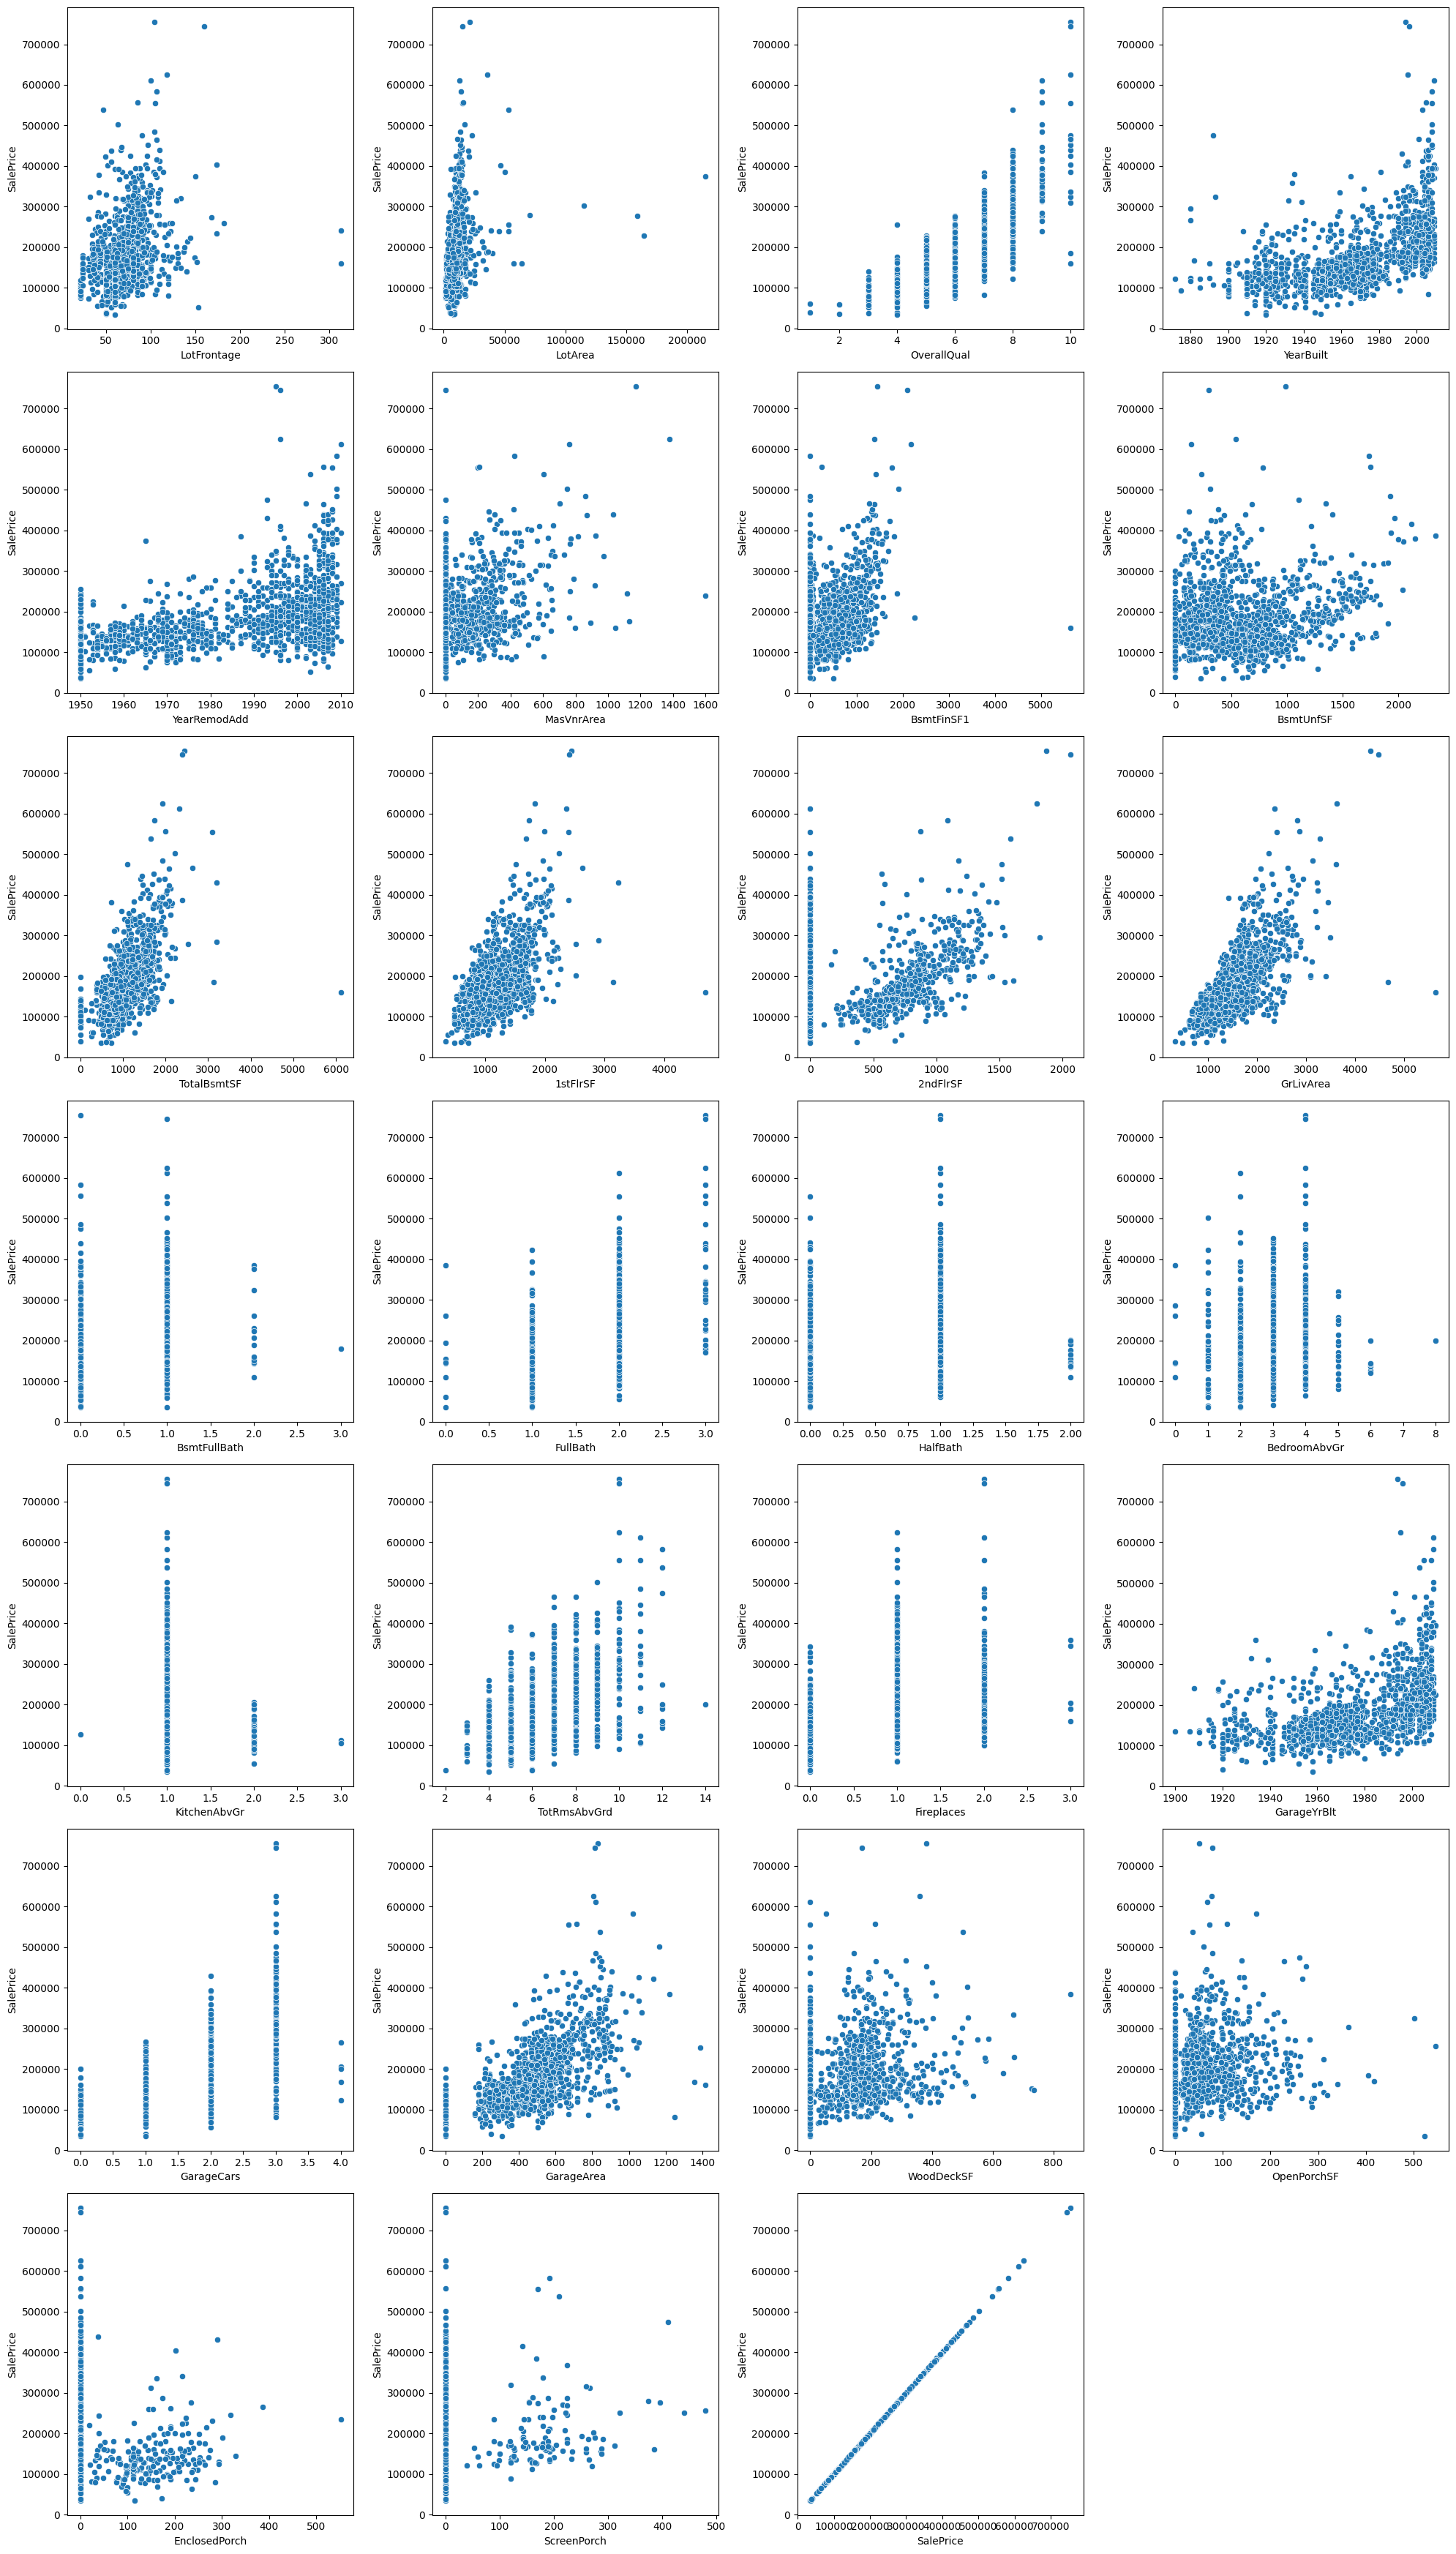

In [25]:
col_number = 4
rows_number = math.ceil(len(numerical_columns)/4)
fig, axes = plt.subplots(rows_number, col_number, figsize = (20,rows_number*5))
axes = axes.flatten()
for i , cols in enumerate(numerical_columns):
    sns.scatterplot(x = df[cols], y= df["SalePrice"], ax = axes[i])

for j in range (i+1,len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()


**Using the Modular Apprroach and Using Numerical Features Only -- Base Mode**

In [ ]:
def run_experiment(feature_names_list, X, y, models):
    current_df = X[feature_names_list]
    current_df.head(3)
    #sampling the data.
    #current_df  = current_df.sample(frac = 1, random_state= 42).reset_index(drop = True)
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(current_df,y,test_size = 0.25, shuffle = True, random_state = 42)
    #Model_training.
    results = []
    for model_name,model  in models.items():
        print(f"Using the {model_name}")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append({
            'Model': model_name,
            'R2_Score': r2,
            'RMSE': rmse,
            'Train_Time_sec': train_time
        })
        results_df = pd.DataFrame(results).sort_values('R2_Score', ascending=False)
        return results_df


NameError: name 'feature_names_list' is not defined

In [91]:
#Importing Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import time 
linear_model = LinearRegression()
random_model = RandomForestRegressor(
    n_estimators=100,  # number of trees
    max_depth=None,     # let trees grow fully
    random_state=42
)
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
xgbmodel = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
model = {"LinearModel":linear_model,
         "TreeBasedModel" :tree_model ,
         "RandomForest" : random_model,
         "XGBoost" :xgbmodel
         
         }
#calling the modular file.
##from experimental_file import run_experiment --failed as i usesd ipynb file instead of py file
X_numerical = df[numerical_columns].drop("SalePrice", axis = 1)
Y_numerical = df["SalePrice"]
highly_related_features = correlations.index.tolist()
highly_related_features.remove('SalePrice')    
select_top = {"Top 10": 10, "Top 15": 15,"Top 20": 20,"All": len(numerical_columns)}
for top, selected_number in select_top.items():
    print(f"Selected {top} and the features name are {highly_related_features[:selected_number]}")
    print("-"*50)
    top_features_name = highly_related_features[:selected_number]
    results  = run_experiment(names = top_features_name, x= X_numerical, y = Y_numerical, model = model)


Selected Top 10 and the features name are ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
--------------------------------------------------


TypeError: run_experiment() got an unexpected keyword argument 'names'

**Data Preprocessing**

**Training and Testing Data Split**

**Model Evaluation**